In [1]:
import numpy as np
import pandas as pd
from tiger.io import read_image, write_image
from tiger.resampling import resample_image, resample_mask
from tiger.patches import PatchExtractor3D
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import random
from sklearn.utils import shuffle

## Data exploration - xVertSeg
1. Load the data and scores
2. Resample images and masks
3. Extract 3D patches from mask (using a centre voxel and fixed size patches)
4. Match the patches with the corresponding scores and check if it makes sense

In [86]:
# 25 images, 15 masks and annotations (img 1-15), (note all in the same order)
img_paths = [os.path.join('../datasets/xvertseg/images', file) for file in sorted(os.listdir('../datasets/xvertseg/images'))]
msk_paths = [os.path.join('../datasets/xvertseg/masks', file) for file in sorted(os.listdir('../datasets/xvertseg/masks'))]
scores = pd.read_csv('../datasets/xvertseg/scores.csv', header=None).to_numpy().reshape(15, 5, 2)

In [3]:
imgs = []
msks = []
hdrs = []

# load images with headers and resample to (1, 1, 1) spacing
for path in tqdm(img_paths):
    image, header = read_image(path)
    resampled_img = resample_image(image, header.spacing, [1, 1, 1])  # resample image
    imgs.append(resampled_img)
    
# load masks
for path in tqdm(msk_paths):
    mask, header = read_image(path)
    resampled_mask = resample_mask(mask, header.spacing, [1, 1, 1])  # resample mask
    msks.append(resampled_mask)

100%|██████████| 15/15 [01:54<00:00,  7.62s/it]


In [91]:
# after loading and resampling we can check an imagine with its mask
i = 0
img = imgs[i]
msk = msks[i] 
score = scores[i]
plt_msk = np.ma.masked_where(msk == 0, msk)

print(img.shape)
print(msk.shape)

(424, 424, 290)
(424, 424, 290)


[array([212, 280, 157]), array([210, 271, 131]), array([207, 266,  99]), array([207, 260,  68]), array([207, 261,  41])]


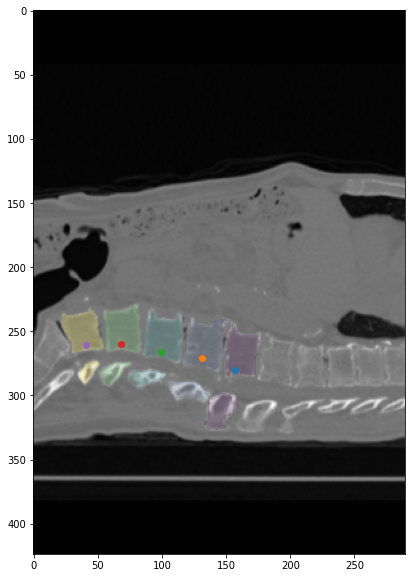

In [92]:
# next we will see how to extract patches of each vertebrae (from the mask) and match them with the scores 
labels = np.unique(msk)[1:]
centres = [np.mean(np.argwhere(msk == l), axis=0, dtype=int) for l in labels]
mid_slice = img.shape[0] // 2
print(centres)

# plot centres
plt.figure(figsize=(10,10))
plt.imshow(img[mid_slice,:,:], cmap='gray')
plt.imshow(plt_msk[mid_slice,:,:], alpha=0.2)

for c in centres:
    y, x = c[1], c[2]
    plt.scatter(x, y)
plt.show()

In [93]:
# 2d or 3d patches?
patch_size = (100, 150, 75)
patch_extracter = PatchExtractor3D(msk)
patches = []

for label, centre in zip(labels, centres):
    patch = patch_extracter.extract_cuboid(centre, patch_size)
    patch = np.where(patch == label, patch, 1)                    # filter patch to only contain this vertebrae
    patches.append(patch)

[[1 3]
 [0 0]
 [1 1]
 [1 1]
 [1 3]]


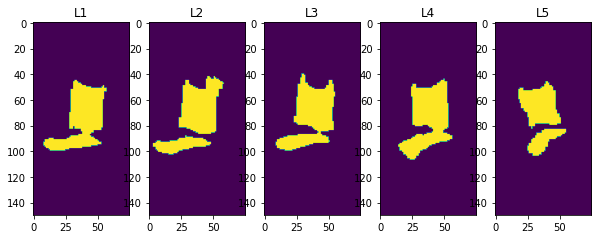

In [94]:
plt.figure(figsize=(10, 10))
print(score)

for i, patch in enumerate(patches):
    plt.subplot(1, 5, i + 1)
    plt.imshow(patch[60,:,:])
    plt.title('L{}'.format(i+1))

Scores are kept in a 5x2 array, consisting of a grade and case for each of the 5 vertebrae ($5*2=10$).

## Creating a simple dataset 
These 3D patches look alright for a first step and we can now match them to the associated scores for each vertrbrae.
In the next step we'll make a simple dataset using what we've just seen.

In [123]:
class Dataset(torch.utils.data.Dataset):
    'Dataset class for a simple dataset containing masks of vertebrae and associated scores.'    
    def __init__(self, scores, masks, patch_size):        
        self.scores = scores.reshape(-1, scores.shape[2])    # N x 2 array, consisting of a grade and case for each of the 5 vertebrae, N is the number of vertebae
        self.patches = []                                    # patch containig the mask of this vertebrae  
        
        # get patches
        for mask in masks:
            labels = np.unique(mask)[1:]
            centres = [np.mean(np.argwhere(mask == l), axis=0, dtype=int) for l in labels]
            patch_extracter = PatchExtractor3D(mask)
            
            for label, centre in zip(labels, centres):
                patch = patch_extracter.extract_cuboid(centre, patch_size)
                patch = np.where(patch == label, patch, 1)                    # filter patch to only contain this vertebrae
                self.patches.append(patch)
            
    def __len__(self):
        "Returns N, the number of vertebrae in this dataset."
        return len(self.patches)

    def __getitem__(self, i):
        "Return a single sample: a patch of mask containing one vertebrae and its score (g, c)"
        X = torch.tensor(self.patches[i])
        y = torch.tensor(self.scores[i])
        return X, y

In [124]:
# lets construct train and validation generators, 
IDs = np.arange(len(msks))     
np.random.shuffle(IDs)

train_val_split = 0.8
n_train = int(0.8 * len(IDs))
train_IDs = IDs[:n_train]
val_IDs = IDs[n_train:]

print(train_IDs)
print(val_IDs)

[ 6 12 13 11  7  4 10  5  3  0  2 14]
[8 1 9]


In [125]:
imgs = np.asarray(imgs)
msks = np.asarray(msks)
patch_size = (100, 150, 75)

# lets construct train and validation generators
train_val_split = 0.8
train_set = Dataset(scores[train_IDs], msks[train_IDs], patch_size)
val_set = Dataset(scores[val_IDs], msks[val_IDs], patch_size)

In [126]:
print(train_set.__len__())
print(train_set.scores.shape)
print(val_set.__len__())
print(val_set.scores.shape)

60
(60, 2)
15
(15, 2)


In [129]:
X, y = train_set.__getitem__(0)
print(X.shape)
print(y.shape)

torch.Size([100, 150, 75])
torch.Size([2])
